# Pet Classifier

In this notebook I am going to develop a CNN using fastai to classify pets into three categories: Cat, Rabbit and Dog.

First I will install fastai and import the necessary libraries.

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastbook import *
from fastai.vision.widgets import *

#Getting the data
To create the dataset used to train and test the model I will use bing image search API.

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

I will organize the data creating a path named "pets1" in which I will create three paths containing the images from each category: pets1/cat/, pets1/dog/ and pets1/rabbit/ .

In [ ]:
pets = "cat", "dog", "rabbit"
path = Path('pets1')

In [ ]:
path.mkdir()

In [ ]:
for o in pets:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o}')
    download_images(dest, urls=results.attrgot('contentUrl'))

After I downloaded the images and saved them into their corresponding paths I can check their file name with this function.

In [ ]:
fns = get_image_files(path)
fns

(#427) [Path('pets1/cat/00000127.jpg'),Path('pets1/cat/00000033.jpg'),Path('pets1/cat/00000076.jpg'),Path('pets1/cat/00000132.jpg'),Path('pets1/cat/00000060.jpg'),Path('pets1/cat/00000020.jpg'),Path('pets1/cat/00000120.jpg'),Path('pets1/cat/00000145.jpg'),Path('pets1/cat/00000006.jpg'),Path('pets1/cat/00000115.jpg')...]

Now I will use verify_images to check if all of this files correspond to actual images.

In [ ]:
failed = verify_images(fns)
failed

(#3) [Path('pets1/cat/00000000.jpg'),Path('pets1/cat/00000119.jpg'),Path('pets1/cat/00000036.jpg')]

I see that some of them don't, so I unlink them.

In [ ]:
failed.map(Path.unlink);

In [ ]:
len(get_image_files(path))

424

# Block

Now I will create the Datablock. This is a particular class from fastai in which I have to specify what kind of data I am going to work with (Images, categories).

Also: 
* ¿how to get the actual images?: With the function get_image_files

* ¿how to split the data?: In this case randomly with a 20% validation set.

* ¿how to get the label?: With the function parent_label.

* And, in this case, because I am working with images I will apply a item_tfms to resize all of them to the same shape.

In [ ]:
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=123),
    get_y=parent_label,
    item_tfms=Resize(128))

Once I have specified how I am going to work with the data, I can create a DataLoader**s** objects, which is basically an object that contain a trainning DataLoder and a validation DataLoader.

In [ ]:
dls = pets.dataloaders(path)

*Is important to understand what is a DataLoader. It consists of an object that divides Datasets (something that if I index on it I will get a tupple with an independent and a dependent variable) into mini-batchs. This mini-batchs are just subsets of the total Dataset that can be passed to the GPU to process them at the same time.*

Now I can use show_batch to show some of the images with their label.

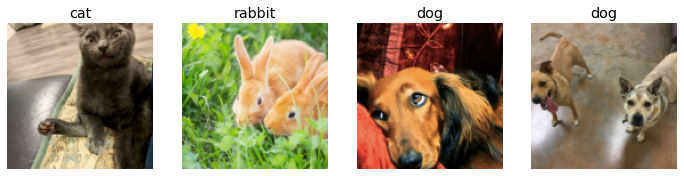

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

#Training model and cleaning data

Before training the model I will use DataBlock.new method to change some of the properties of the DataBlock created before:

* I will use a RamdomResizedCrop with a size of 224 to resize all the images.

* I will also applu aug_transforms to every batch. This basically consist on image augmentation.

In [ ]:
pets = pets.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = pets.dataloaders(path)

Now I will show a subset of the new data. Some of the images seems to have weird angles, this is due to the image augmentation.
In case of wanting to show all the different versions used for a unique image, you can set the argument: unique = True.

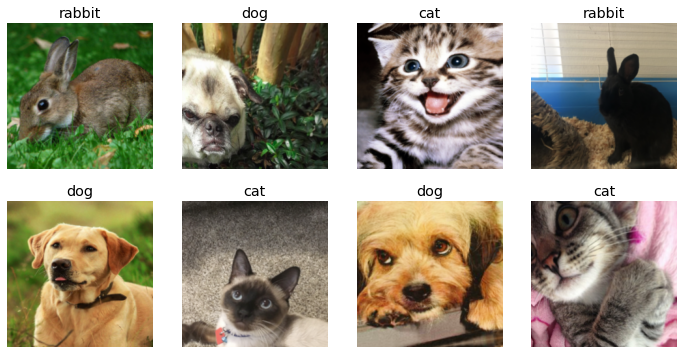

In [ ]:
dls.train.show_batch(max_n=8, nrows=2)

Now I will train the model with default learning rate using transfer learning. This refers to the use of a model that has already being trained (resnet18) to train it again with new data (fine_tune).



In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.577193,0.285818,0.095238,00:11


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.334822,0.066259,0.023810,00:11
1,0.214360,0.036275,0.011905,00:12


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


After just two epochs I am getting almost 99% accuracy on the validation set! So I will stop here. 

Looking at the confusion matrix I see that it's mistake was classifying a dog as a rabbit. 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


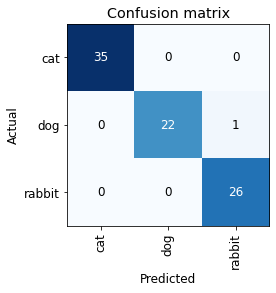

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Looking at the predictions where the algorithm was less confident about I see that the error was made in an image in which appears two dog puppies instead of one. 

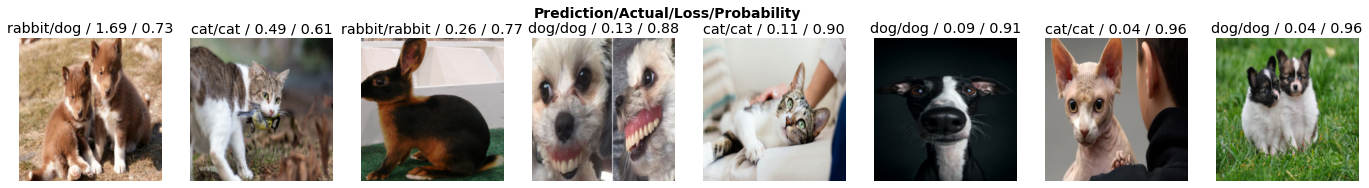

In [ ]:
interp.plot_top_losses(8, nrows=1)

For simplicity I won't clean the data and repeat again the training because the results are already quite good.

But it could be done using ImageClassifierCleaner by tagging in its GUI the images as \<Keep\>, their correct category or \<Delete\> and executing the two lines of code below.

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Inference

To finish I will use the method .export to save the model (architecture and parameters) and the definition of how to create the DataLoaders. I will name it "export.pkl"

In [ ]:
learn.export()


In [ ]:
path = Path()
path.ls(file_exts='.pkl')


(#1) [Path('export.pkl')]

In [ ]:
from google.colab import files


In [ ]:
files.download('export.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

At the moment you want to use the model for inference it can be loaded this way:

In [ ]:
learn_inf = load_learner(path/'export.pkl')
